# Introduction 

We have seen that Newton's method is very successful even with a troublesome function such as Rosenbrock. However, the true Hessian can be expensive and/or difficult to evaluate. _Quasi-Newton_ methods use approximations to the Hessian, easier to evaluate, and still converge quickly.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

Consider the Rosenbrock function
$$f(x,y)=10(y-x^2)^2 + (1-x)^2$$
with gradient
$$\nabla f = \left[\begin{array}{c}
40x^3 - 40xy +2x - 2 \\\
20(y-x^2)
\end{array}\right]$$
and Hessian
$$\nabla^2 f = \left[
\begin{array}{c}
120x^2-40y+2 & -40x \\\
-40x & 20
\end{array}\right]$$
The only minimum is at $(x,y)=(1,1)$ where $f(1,1)=0$.

In [2]:
def objfun(x,y):
    return 10*(y-x**2)**2 + (1-x)**2
def gradient(x,y):
    return np.array([-40*x*y + 40*x**3 -2 + 2*x, 20*(y-x**2)])
def hessian(x,y):
    return np.array([[120*x*x - 40*y+2, -40*x],[-40*x, 20]])

Create a utility function that plots the contours of the Rosenbrock function.

In [3]:
def contourplot(objfun, xmin, xmax, ymin, ymax, ncontours=50, fill=True):

    x = np.linspace(xmin, xmax, 200)
    y = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(x,y)
    Z = objfun(X,Y)
    if fill:
        plt.contourf(X,Y,Z,ncontours); # plot the contours
    else:
        plt.contour(X,Y,Z,ncontours); # plot the contours
    plt.scatter(1,1,marker="x",s=50,color="r");  # mark the minimum

Here is a contour plot of the Rosenbrock function, with the global minimum marked with a red cross.

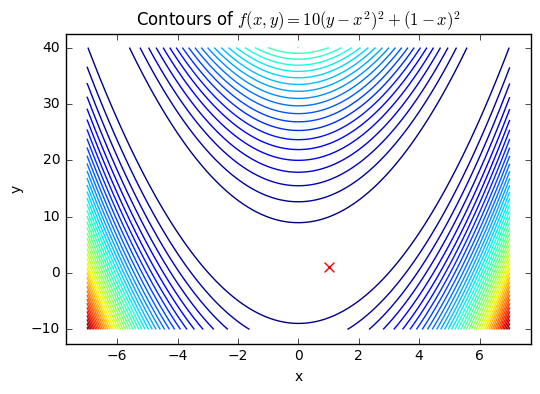

In [7]:
contourplot(objfun, -7,7, -10, 40, fill=False)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Contours of $f(x,y)=10(y-x^2)^2 + (1-x)^2$");

# Symmetric-rank-one (SR1) method

We write a function the SR1 quasi-Newton method to minimize a given objective function. Starts the solution at position `init`, moves along the quasi-Newton direction $-B_k^{-1}\nabla f$ until the absolute difference between function values drops below `tolerance` or until the number of iterations exceeds `maxiter`.

The approximate Hessian is initialized with an identity matrix.

The method is not self-starting: In order to calculate $B_1$, we need $x_1$ and $\nabla f_1$. So in the first step we do a simple gradient descent.

The step length $\alpha$ is not used here, effectively set to 1.

For efficiency, we use `np.linalg.solve` to determine the descent direction, instead of inverting the Hessian matrix. Inversion is no big deal in this 2D system, but that's a good habit to follow.

The function returns the array of all intermediate positions, and the array of function values.

In [82]:
def sr1(objfun, gradient, init, tolerance=1e-6, maxiter=10000):
    x = np.array(init)
    iterno = 0
    B = np.identity(2)
    xarray = [x]
    fprev = objfun(x[0],x[1])
    farray = [fprev]
    gprev = gradient(x[0],x[1])
    xtmp = x - 0.01*gprev/np.sqrt(np.dot(gprev,gprev))
    gcur = gradient(xtmp[0],xtmp[1])
    s = xtmp-x
    y = gcur-gprev
    while iterno < maxiter:
        r = y-np.dot(B,s)
        B = B + np.outer(r,r)/np.dot(r,s)        
        x = x - np.linalg.solve(B,gcur)
        fcur = objfun(x[0], x[1])
        if np.isnan(fcur):
            break
        gprev = gcur
        gcur = gradient(x[0],x[1])
        xarray.append(x)
        farray.append(fcur)
        if abs(fcur-fprev)<tolerance:
            break
        fprev = fcur
        s = xarray[-1]-xarray[-2]
        y = gcur-gprev
        iterno += 1
    return np.array(xarray), np.array(farray)

Now let's see how Newton's method behaves with the Rosenbrock function.

In [83]:
p, f = sr1(objfun, gradient, init=[2,4])

In [84]:
f

array([  1.00000000e+00,   7.93803691e-01,   6.67688855e+00,
         6.78695954e-01,   5.89167649e-01,   3.92616071e-01,
         2.56986873e-01,   2.15464394e-01,   1.35741339e-01,
         8.94575262e-02,   9.09671247e-02,   2.76842389e-02,
         8.71978686e-01,   1.82697833e-03,   7.00060960e-04,
         3.87821253e-06,   1.15464551e-07,   6.00017272e-09])

Plot the convergence of the solution. Left: The solution points (white) superposed on the contour plot. The star indicates the initial point. Right: The objective function value at each iteration.

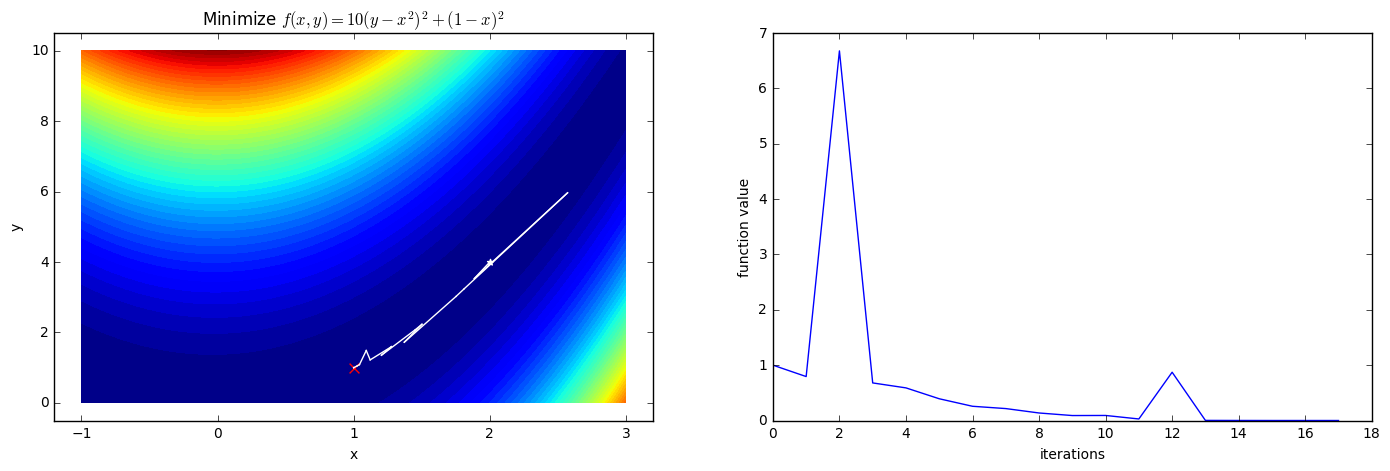

In [85]:
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
contourplot(objfun, -1,3,0,10)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Minimize $f(x,y)=10(y-x^2)^2 + (1-x)^2$");
plt.scatter(p[0,0],p[0,1],marker="*",color="w")
for i in range(1,len(p)):    
        plt.plot( (p[i-1,0],p[i,0]), (p[i-1,1],p[i,1]) , "w");

plt.subplot(1,2,2)
plt.plot(f)
plt.xlabel("iterations")
plt.ylabel("function value");

The minimum is found in less than 20 iterations, with some zig-zagging around the minimum. Not as good as Newton's method, but definitely much better than steepest descent.

Now let's start at a more difficult location.

In [86]:
p, f = sr1(objfun, gradient, init=[-1,9])

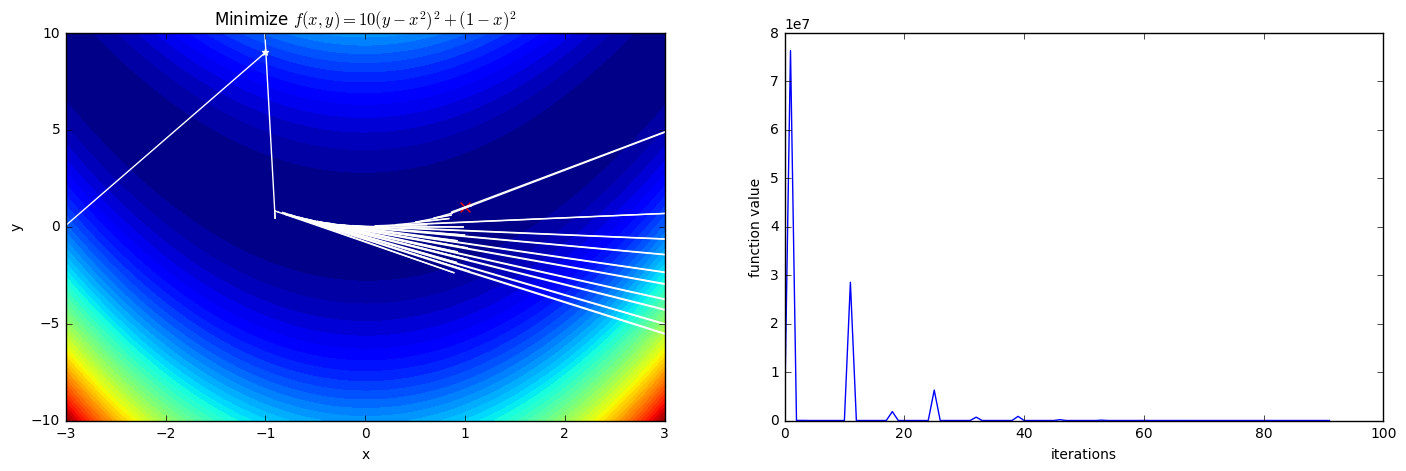

In [87]:
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
contourplot(objfun, -3,3,-10,10)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Minimize $f(x,y)=10(y-x^2)^2 + (1-x)^2$");
plt.scatter(p[0,0],p[0,1],marker="*",color="w")
for i in range(1,len(p)):    
        plt.plot( (p[i-1,0],p[i,0]), (p[i-1,1],p[i,1]) , "w");
plt.xlim(-3,3)
plt.ylim(-10,10)
        
plt.subplot(1,2,2)
plt.plot(f)
plt.xlabel("iterations")
plt.ylabel("function value");

There are many large oscillations in the results. It may be the result of the denominator becoming almost zero, or the rsult of some mistake I've done. I'll return to this later.